# Importing libraries

In [ ]:
!pip install cleanlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 19.7 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import random_split, Dataset, DataLoader, ConcatDataset, Subset
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import train_test_split
from torchsummary import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

!wget https://raw.githubusercontent.com/TrasperJ/102-flowers-classfication-with-PyTorch/master/flower_to_name.json

--2023-07-07 20:22:29--  https://raw.githubusercontent.com/TrasperJ/102-flowers-classfication-with-PyTorch/master/flower_to_name.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2219 (2.2K) [text/plain]
Saving to: ‘flower_to_name.json’

flower_to_name.json 100%[===================>]   2.17K  --.-KB/s    in 0s      

2023-07-07 20:22:29 (41.7 MB/s) - ‘flower_to_name.json’ saved [2219/2219]



# Data preprocessing

In [ ]:
#data loading

transform = transforms.Compose([transforms.Resize((224, 224)),
                         transforms.ToTensor(),
                         #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                         ])


data_train = datasets.Flowers102(download = True, split = 'train', transform = transform, root = "Dataset")
data_val = datasets.Flowers102(download = True, split = 'val', transform = transform, root = "Dataset")
data_test = datasets.Flowers102(download = True, split = 'test', transform = transform, root = "Dataset")

data = ConcatDataset([data_train, data_val, data_test])
data.targets = torch.Tensor(data_train._labels + data_val._labels + data_test._labels)

In [ ]:
#flower categories to ids

import json
with open('flower_to_name.json', 'r') as f:
  flower_to_name = json.load(f)


labels = ['frangipani', 'camellia', 'gazania', 'barbeton daisy', 'hippeastrum', 'sweet william', 'primula']
ood_labels = ['oxeye daisy', 'daffodil', 'yellow iris']
labels_idx = []
ood_labels_idx = []


#lables idx pairs
for idx, name in flower_to_name.items():
  if name in labels:
    labels_idx.append(int(idx))
  if name in ood_labels:
    ood_labels_idx.append(int(idx))

In [ ]:
#separate ood and id ids

_idx = []
_OODidx = []

for id in labels_idx:
  ind = torch.where(data.targets == id)
  _idx.append(list(ind))

for id in ood_labels_idx:
  ind = torch.where(data.targets == id)
  _OODidx.append(list(ind))

In [ ]:
#train test split

#sample selection
train_idx = np.hstack([np.random.choice(x[0], int(0.8*len(x[0])), replace = False) for x in _idx])
test_idx = np.hstack([np.setdiff1d(_idx[i][0].detach().cpu().numpy(), train_idx[i]) for i in range(len(_idx))])
ood_idx = np.hstack([np.random.choice(x[0], 25) for x in _OODidx])



#Find subsets
training_data = Subset(data, train_idx)

#id test data
test_data = Subset(data, test_idx)

#id + ood test data
test_ood_data = Subset(data, np.hstack((test_idx, ood_idx)))


In [ ]:
#modify labels for the new classifier head
def map_labels(label):
  return torch.Tensor([labels_idx.index(x) for x in label])



# Feature Extraction with VGG19

## Initialize model with a new classifier head

In [ ]:
model = torchvision.models.vgg19(pretrained=True)


for param in model.features.parameters():
  param.requires_grad = False

#setting a new classifier from scratch
model.classifier = nn.Sequential(model.classifier,
                                 nn.ReLU(),
                                 nn.Dropout(p = 0.5),
                                 nn.Linear(1000, 7))
model.cuda()

summary(model.cuda(), (3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 91.8MB/s]


RuntimeError: ignored

## Training

In [ ]:
#Hyperparameters and configs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 1e-3
weight_decay = 1e-4
num_epochs = 20
batch_size = 8

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=30)

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
#training

loss_train = []
loss_validation = []

#device = 'cpu'

for epoch in range(num_epochs):
  for i, (input, target) in enumerate(train_dataloader):

          target = map_labels(target).type(torch.LongTensor).to(device)
          input = input.to(device)

          # compute output
          output = model(input)
          loss = criterion(output, target)
          loss_train.append(loss.item())

          # backpropagate
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_dataloader), loss.item()))

  before_lr = optimizer.param_groups[0]["lr"]
  scheduler.step()
  after_lr = optimizer.param_groups[0]["lr"]
  print("------- Epoch %d: lr %.4f -> %.4f" % (epoch+1, before_lr, after_lr))

## Test

In [ ]:
#testing
loss_test = []


with torch.no_grad():
  correct = 0
  total = 0
  for i, (input, target) in enumerate(test_dataloader):

        target = map_labels(target).type(torch.LongTensor).to(device)
        input = input.to(device)

        # compute output
        output = model(input)
        loss = criterion(output, target)
        loss_test.append(loss.item())

        total += target.size(0)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()

  print('Accuracy on the test images: {} %'.format(100 * correct / total))

## Save model

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# torch.save(model.state_dict(),'/content/drive/MyDrive/SML Model/model.pt')

## Feature extraction using penultimate layers' activations

In [ ]:
# a dict to store the activations
activation = {}
def getActivation(name):
  # the hook signature
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook


# register forward hooks on the layers of choice
h1 = model.classifier[0][6].register_forward_hook(getActivation('feats'))

In [ ]:
# model = torchvision.models.vgg19()
# model.classifier = nn.Sequential(model.classifier,
#                                  nn.ReLU(),
#                                  nn.Dropout(p = 0.5),
#                                  nn.Linear(1000, 7))

# model.load_state_dict(torch.load('/content/drive/MyDrive/SML Model/model.pt'))
# model.cuda()

In [ ]:
feats_test, labels_test, feats_train, labels_train = [], [], [], []

for data in test_ood_data:
  x = data[0]
  labels_test.append(data[1])
  x = x.to(device)
  x=x.reshape((1,3,224,224))
  out = model(x)
  feats_test.append(activation['feats'])

for data in training_data:
  x = data[0]
  labels_train.append(data[1])
  x = x.to(device)
  x=x.reshape((1,3,224,224))
  out = model(x)
  feats_train.append(activation['feats'])


#Numpify the features!
feats_test_d = np.zeros((len(test_ood_data),1000))
labels_test_d = np.zeros((len(test_ood_data)))

feats_train_d = np.zeros((len(training_data),1000))
labels_train_d = np.zeros((len(training_data)))

for i in range(len(feats_test)):
  feats_test_d[i,:] = feats_test[i].cpu().numpy()
  labels_test_d[i] = labels_test[i]

for i in range(len(feats_train)):
  feats_train_d[i,:] = feats_train[i].cpu().numpy()
  labels_train_d[i] = labels_train[i]

h1.remove()

In [ ]:
#Save extracted features

np.save('/content/drive/MyDrive/SML Model/feats_test', feats_test_d)
np.save('/content/drive/MyDrive/SML Model/feats_train', feats_train_d)
np.save('/content/drive/MyDrive/SML Model/labels_test', labels_test_d)
np.save('/content/drive/MyDrive/SML Model/labels_train', labels_train_d)

## Load Extracted Features

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Save extracted features

feats_test_d = np.load('/content/drive/MyDrive/SML Model/feats_test.npy')
feats_train_d = np.load('/content/drive/MyDrive/SML Model/feats_train.npy')
labels_test_d = np.load('/content/drive/MyDrive/SML Model/labels_test.npy')
labels_train_d = np.load('/content/drive/MyDrive/SML Model/labels_train.npy')

In [ ]:
X_train = feats_train_d
y_train = labels_train_d

X_test = feats_test_d
y_test = labels_test_d


labels = np.unique(y_train)

# Classifying seen and unseen classes in test by OOD detection

## Mahalanobis

In [ ]:
class Mahalanobis():
  def __init__(self):
    self.covs = []
    self.cov = None
    self.means = []
    self.nb_classes = None
    self.inv_cov = None
    self.X_train = None
    self.normalizing_factor = 1

  def fit(self, X_train, y_train):

    self.X_train = X_train
    classes = np.unique(y_train)
    self.nb_classes = len(classes)
    class_indices = []
    for i in range(self.nb_classes):
      class_indices.append(y_train == classes[i])


    for i in range(self.nb_classes):
      self.means.append(np.mean(X_train[class_indices[i]]))
      self.covs.append((X_train[class_indices[i]] - self.means[i]).T@(X_train[class_indices[i]] - self.means[i]))

    self.cov = np.zeros(self.covs[0].shape)

    for i in range(self.nb_classes):
      self.cov += self.covs[i]

    self.cov /= len(self.covs)

    means_np = np.zeros((len(y_train), self.cov.shape[0]))

    for i in range(self.nb_classes):
      means_np[i] = self.means[i]

    self.means = means_np
    self.inv_cov = np.linalg.inv(self.cov)
    self.normalize()


  def predict(self, x, subtract_mean = True):

    if (len(x.shape) != 1 and x.shape[0] != 1 and x.shape[1] != 1):
      dists = np.zeros((x.shape[0], 1))
      for i in range(x.shape[0]):
        dists[i] = self.predict(x[i,:], subtract_mean)
      return dists

    if not subtract_mean:
      return -np.min((x)@(self.inv_cov)@(x).T)/self.normalizing_factor

    return -np.min((x - self.means)@(self.inv_cov)@(x - self.means).T)/self.normalizing_factor


  def normalize(self):
    self.normalizing_factor = np.linalg.norm(self.predict(self.X_train))




## Cross-validation for thresholds

In [ ]:
import numpy as np


def cross_val_ood(model, params, x_train, y_train):
  class_indices_train = []
  train_labels = np.unique(y_train)
  nb_classes = len(train_labels)

  for i in range(nb_classes):
    class_indices_train.append(y_train == train_labels[i])

  if (model == 'rbf_threshold'):

    from sklearn.ensemble import RandomForestClassifier as RFC

    params['best'] = 0

    best_score = 0
    #uncertainty estimation
    for threshold in params['threshold']:

      f1_class_mean = 0
      for i in range(nb_classes):
        rf = RFC().fit(X_train[~class_indices_train[i]], y_train[~class_indices_train[i]])
        prob = rf.predict_proba(X_train[class_indices_train[i]])
        prob_train = rf.predict_proba(X_train[~class_indices_train[i]])

        acc_train = np.sum((prob_train.max(axis = 1) > threshold))/len(prob_train)
        acc_test = np.sum((prob.max(axis = 1) < threshold))/len(prob)
        f1_class_mean += ((acc_train*acc_test)/(acc_train+acc_test))/nb_classes

      if (f1_class_mean > best_score):
        best_score = f1_class_mean
        params['best'] = threshold

    return params


  elif (model == 'knn_odd'):

    from cleanlab.outlier import OutOfDistribution

    params['best'] = 0

    best_score = 0
    #uncertainty estimation
    for threshold in params['threshold']:

      f1_class_mean = 0
      for i in range(nb_classes):
        ood = OutOfDistribution()
        # To get outlier scores for train_data using feature matrix train_feature_embeddings
        ood_train_feature_scores = ood.fit_score(features=X_train[~class_indices_train[i]])
        # To get outlier scores for additional test_data using feature matrix test_feature_embeddings
        ood_test_feature_scores = ood.score(features=X_train[class_indices_train[i]])
        acc_train = sum(ood_train_feature_scores > threshold)/len(ood_train_feature_scores)
        acc_test = np.sum(ood_test_feature_scores < threshold)/len(ood_test_feature_scores)
        f1_class_mean += ((acc_train*acc_test)/(acc_train+acc_test))/nb_classes

      if (f1_class_mean > best_score):
        best_score = f1_class_mean
        params['best'] = threshold


  elif (model == 'mahalanobis'):

    params['best'] = 0
    best_score = 0
    #uncertainty estimation
    for threshold in params['threshold']:

      f1_class_mean = 0
      for i in range(nb_classes):
        mahalanobis = Mahalanobis()
        # To get outlier scores for train_data using feature matrix train_feature_embeddings
        mahalanobis.fit(X_train[~class_indices_train[i]], y_train[~class_indices_train[i]])
        train_dists = mahalanobis.predict(X_train[~class_indices_train[i]])
        # To get outlier scores for additional test_data using feature matrix test_feature_embeddings
        test_dists = mahalanobis.predict(X_train[~class_indices_train[i]])

        acc_train = sum(train_dists > threshold)/len(train_dists)
        acc_test = np.sum(test_dists < threshold)/len(test_dists)
        f1_class_mean += ((acc_train*acc_test)/(acc_train+acc_test))/nb_classes

      if (f1_class_mean > best_score):
        best_score = f1_class_mean
        params['best'] = threshold

    return params



  else:
    return None




In [ ]:
params = {'threshold': [0.5, 0.6, 0.7, 0.8, 0.85]}

params = cross_val_ood('rbf_threshold', params, X_train, y_train)

## OOD detection with entropy

In [ ]:
#Calcculating entropy of OOD

import scipy

ood_test_dataloader = DataLoader(test_ood_data, batch_size = 1, shuffle = True)
Ent_ood = []

with torch.no_grad():
  for i, (input, target) in enumerate(ood_test_dataloader):

        target = target.type(torch.LongTensor).to(device)
        input = input.to(device)
        # compute output
        output = model(input)

        soft_out = torch.softmax(output[0], dim=0)
        val, predicted = torch.max(soft_out.data, 0)
        Ent_ood.append(val)

In [ ]:
#Creating boolean lists for members of each train class
class_indices = []

for i in range(len(labels)):
  class_indices.append((y_train == labels[i]))

#Creating boolean lists for members of each test class
class_indices_test = []
test_labels = np.unique(y_test)

for i in range(len(test_labels)):
  class_indices_test.append(y_test == test_labels[i])

## OOD detection by Mahalanobis distance

In [ ]:
#Calculating means and covariances for features

means = []
covs = []

for i in range(len(labels)):
  means.append(np.mean(X_train[class_indices[i]]))
  covs.append((X_train[class_indices[i]] - means[i]).T@(X_train[class_indices[i]] - means[i]))

cov = np.zeros(covs[0].shape)

for i in range(len(covs)):
  cov += covs[i]

cov /= len(covs)

means_np = np.zeros((len(labels), cov.shape[0]))

for i in range(len(means)):
  means_np[i] = means[i]

# inverse of covariance
inv_cov = np.linalg.inv(cov)

In [ ]:
# Mahalanobis distance

def m_distance(x, inv_cov, means, subtract_mean = True):

  if not subtract_mean:
    return -np.min((x)@(inv_cov)@(x).T)

  return -np.min((x - means)@(inv_cov)@(x - means).T)

In [ ]:
#Calculating Mahalanobis distance for test data

test_ood_distances = []
test_id_distances = []
id_distances = []

for i in range(len(X_train)):
  id_distances.append(m_distance(X_train[i], inv_cov, means_np))

for i in range(len(X_test)):
  #in distribution
  if (y_test[i] in labels):
    test_id_distances.append(m_distance(X_test[i], inv_cov, means_np))

  #ood
  else:
    test_ood_distances.append(m_distance(X_test[i], inv_cov, means_np))

In [ ]:
test_ood_distances = []
test_id_distances = []
id_distances = []

for i in range(len(X_train)):
  id_distances.append(m_distance(X_train[i], inv_cov, means_np, subtract_mean = False))

for i in range(len(X_test)):
  #in distribution
  if (y_test[i] in labels):
    test_id_distances.append(m_distance(X_test[i], inv_cov, means_np, subtract_mean = False))

  #ood
  else:
    test_ood_distances.append(m_distance(X_test[i], inv_cov, means_np, subtract_mean = False))

In [ ]:
id_distances = np.array(id_distances)
test_ood_distances = np.array(test_ood_distances)
test_id_distances = np.array(test_id_distances)

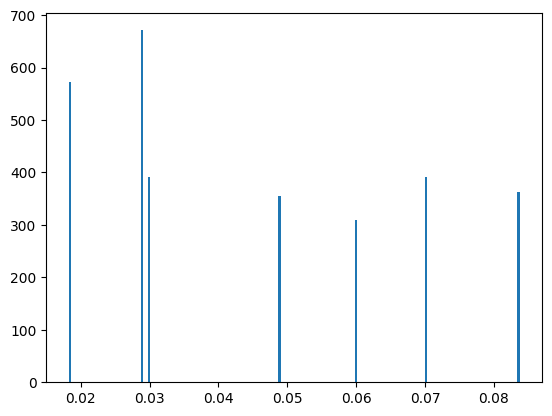

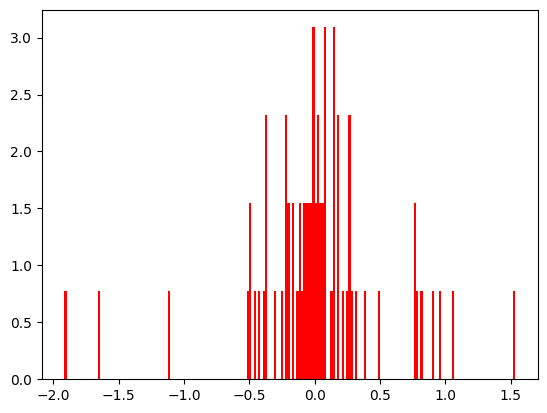

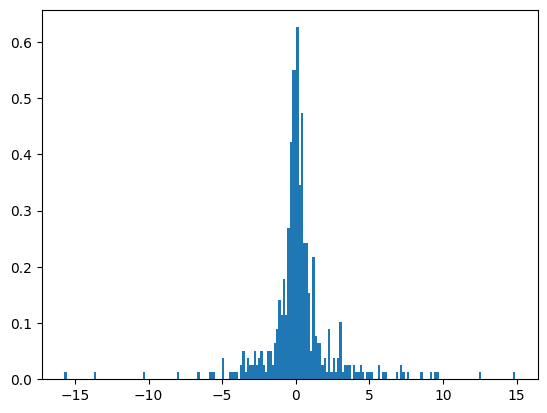

In [ ]:
#Plots for m-distances' dist. of train and test (ood and id) data
import matplotlib.pyplot as plt

plt.hist(id_distances/np.linalg.norm(id_distances), density=True, bins=200);

plt.figure();
plt.hist(test_ood_distances/np.linalg.norm(id_distances), density=True, bins=200, color='r');

plt.figure();
plt.hist(test_id_distances/np.linalg.norm(id_distances), density=True, bins=200);

plt.show();

## OOD detection with cleanlab (K-nn distance)

In [ ]:
#seperating ood and id indecies in test dataset

ood_ind = []
id_test = []

for i in range(len(y_test)):
  if (y_test[i] not in labels):
    ood_ind.append(i)
  else:
    id_test.append(i)

In [ ]:
from cleanlab.outlier import OutOfDistribution

ood = OutOfDistribution()

# To get outlier scores for train_data using feature matrix train_feature_embeddings
ood_train_feature_scores = ood.fit_score(features=X_train)

# To get outlier scores for additional test_data using feature matrix test_feature_embeddings
ood_test_feature_scores = ood.score(features=X_test[ood_ind])

# To get outlier scores for additional test_data using feature matrix test_feature_embeddings
ood_test_id_feature_scores = ood.score(features=X_test[id_test])

Fitting OOD estimator based on provided features ...


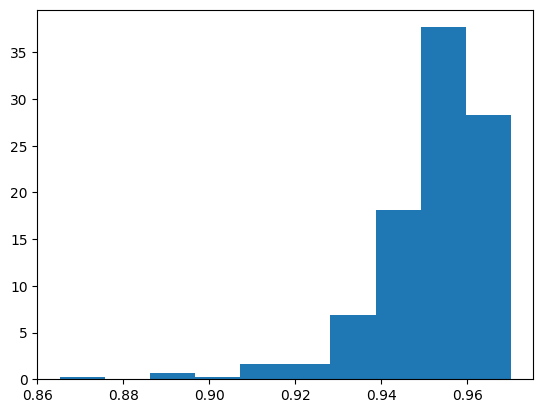

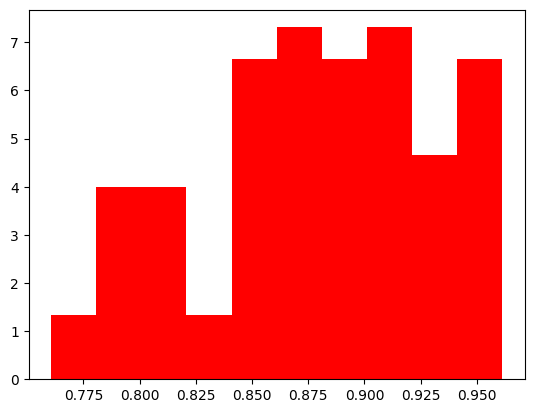

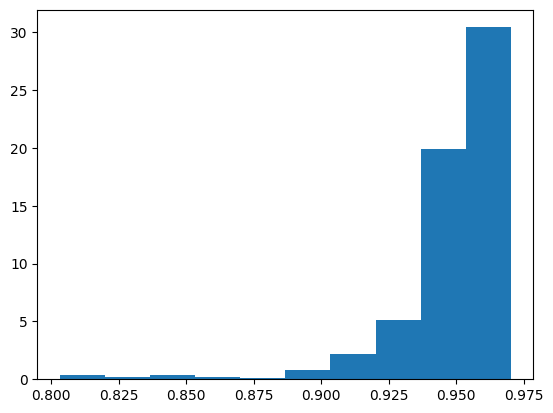

In [ ]:
#Plots for K-nn dist. of train and test (ood and id) data

plt.hist(ood_train_feature_scores, density=True, bins=10)

plt.figure()
plt.hist(ood_test_feature_scores, density=True, bins=10, color='r')

plt.figure()
plt.hist(ood_test_id_feature_scores, density=True,bins = 10)

plt.show()

In [ ]:
threshold = .9

print(np.sum(ood_train_feature_scores > threshold)/len(ood_train_feature_scores))
print(np.sum(ood_test_feature_scores < threshold)/len(ood_test_feature_scores))
print(np.sum(ood_test_id_feature_scores > threshold)/len(ood_test_id_feature_scores))

0.9901234567901235
0.6266666666666667
0.9667318982387475


## OOD detection by random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC

rf = RFC().fit(X_train, y_train)

prob = rf.predict_proba(X_test)
prob_train = rf.predict_proba(X_train)

In [ ]:
#uncertainty estimation
threshold = 0.90

print('odd accuracy on training data: ', np.sum((prob_train.max(axis = 1) > threshold))/len(X_train))
print('odd accuracy on ood test data: ', np.sum((prob[ood_ind].max(axis = 1) < threshold))/len(X_test[ood_ind]))
print('odd accuracy on id test data: ', np.sum((prob[id_test].max(axis = 1) > threshold))/len(X_test[id_test]))

odd accuracy on training data:  0.980246913580247
odd accuracy on ood test data:  0.7866666666666666
odd accuracy on id test data:  0.8512720156555773


## OOD detection after PCA

# Clustering unseen test data

## T-SNE & PCA

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#Decreasing dimension of data with t-sne
tsne = TSNE(n_components = 2)
x_test_tsne = tsne.fit_transform(X_test[ood_ind])

#Decreasing dimension of data with pca
pca = PCA(n_components = 2)
x_pca = pca.fit_transform(X_test[ood_ind])

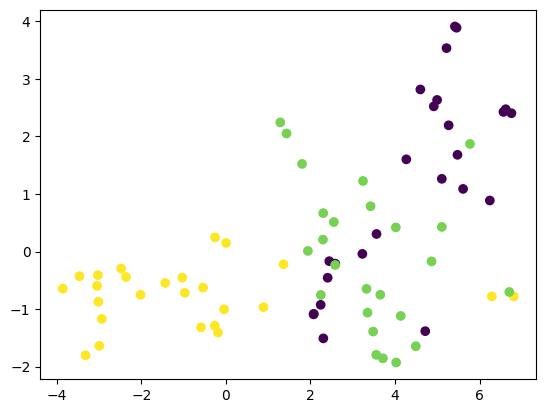

In [ ]:
# t-sne plot
plt.scatter(x_test_tsne[:,0],x_test_tsne[:,1], c=y_test[ood_ind]);

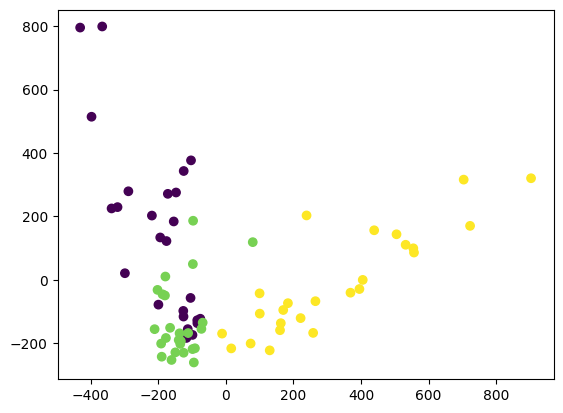

In [ ]:
# pca plot
plt.scatter(x_pca[:,0], x_pca[:,1], c=y_test[ood_ind]);

## Bayesian Gaussian Mixture (NPB)

% BGM

In [ ]:
from sklearn.mixture import BayesianGaussianMixture as BGM

bgm = BGM(n_components = 5, covariance_type='full').fit(x_pca)


labels_ = bgm.predict(x_pca)


from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
nmi = NMI(y_test[ood_ind], labels_)
print("NMI: %.4f" % nmi)
print(f'estimated uneen classes {len(np.unique(labels_))}')


NMI: 0.5603
estimated uneen classes 4


In [ ]:
from sklearn.metrics import adjusted_rand_score as ars

print(f'ARS: {ars(y_test[ood_ind],labels_)}')

ARS: 0.5026509734902651


# Classifing seen classes in test

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA


pca_train = PCA(n_components = 5)


svc = SVC().fit(pca_train.fit_transform(X_train), y_train)

print(f'SVM acc: {svc.score(pca_train.transform(X_test[id_test]), y_test[id_test])}')

SVM acc: 0.9647749510763209
